Student Name: Paul Fagan

Student Number: 23254777

# Predicting insurance costs

### Data Dictionary



**Input variables**:

- `age`: age of primary beneficiary

- `sex`: insurance contractor gender, female, male
- `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- `children`: Number of children covered by health insurance / Number of dependents

- `smoker`: Smoking

- `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- `charges`: Individual medical costs billed by health insurance

**Output variable (desired target)**:
-  `insurance costs`:

### Import Python Modules

In [104]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Classification  algorithms
from sklearn.ensemble import RandomForestClassifier

# metrics for evaluating Classification models
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter out ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)




### Utility Functions

In [182]:
def evaluate_model_cfc(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [47]:
def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

### Import dataset

In [136]:
df = pd.read_csv("insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

## Task 1:Classification

Objective: train three classification pipelines with SVM, Random Forest and a third classifier of your choice as the final estimator to train a model that predicts the value of `insurance_cost_binary`.

In [137]:
df_clf = df.copy()

Transforming the insurance cost into a binary variable to use it as a target variable in a classification task.

In [138]:
median_insurance_cost = df_clf['insurance_cost'].median()

df_clf['insurance_cost_binary'] = (df_clf['insurance_cost'] > median_insurance_cost).astype(int)

df_clf.drop(columns=['insurance_cost'], inplace=True)

df_clf.head()

age  gender     bmi  children smoker     region  insurance_cost_binary
0   18    male  33.770         1     no  southeast                      0
1   18    male  34.100         0     no  southeast                      0
2   18  female  26.315         0     no  northeast                      0
3   18  female  38.665         2     no  northeast                      0
4   18  female  35.625         0     no  northeast                      0

### EDA - Exploratory Data Analysis

In [139]:
df_clf['insurance_cost_binary'].value_counts()

insurance_cost_binary
0    669
1    669
Name: count, dtype: int64

In [140]:
df_clf.describe()

age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.500000
std      14.049960     6.098187     1.205493               0.500187
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               0.500000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

In [141]:
df_clf.isna().sum()

age                      0
gender                   0
bmi                      0
children                 0
smoker                   0
region                   0
insurance_cost_binary    0
dtype: int64

There are no missing values. 

In [142]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1338 non-null   int64  
 1   gender                 1338 non-null   object 
 2   bmi                    1338 non-null   float64
 3   children               1338 non-null   int64  
 4   smoker                 1338 non-null   object 
 5   region                 1338 non-null   object 
 6   insurance_cost_binary  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.3+ KB


- Categorical: We have 3 nomimal variables smoker, region, gender not including our target variable

- Numerical:  We have 3 numiercal variables Age, BMI, Children 

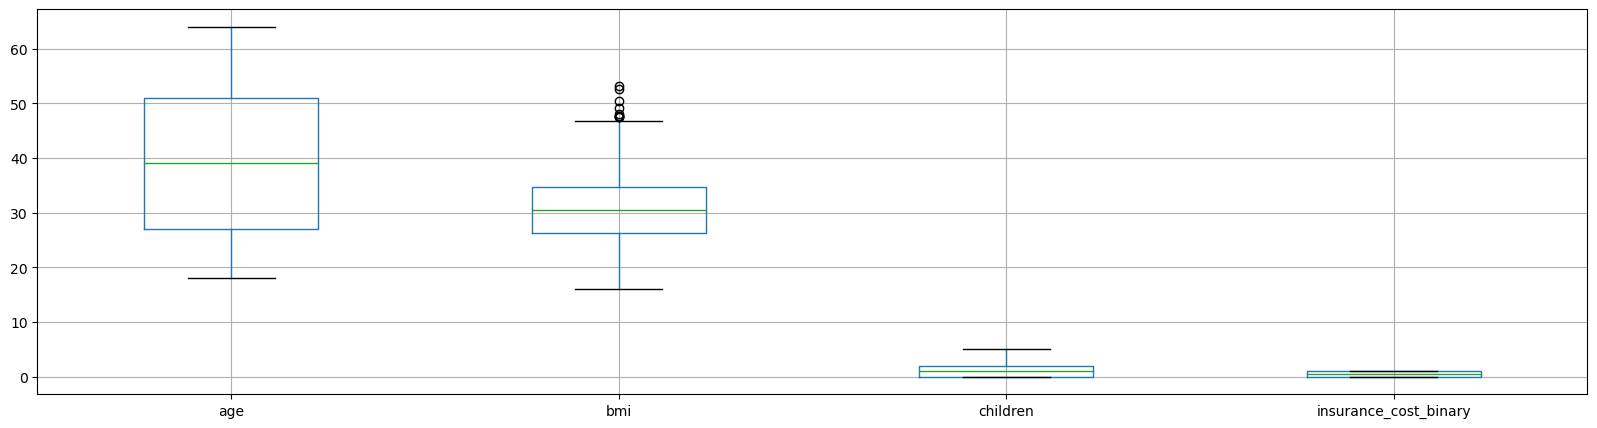

In [143]:
df_clf.boxplot(figsize=(20, 5))
plt.show()

- BMI has outliers, but the rest of the numerical variables do not

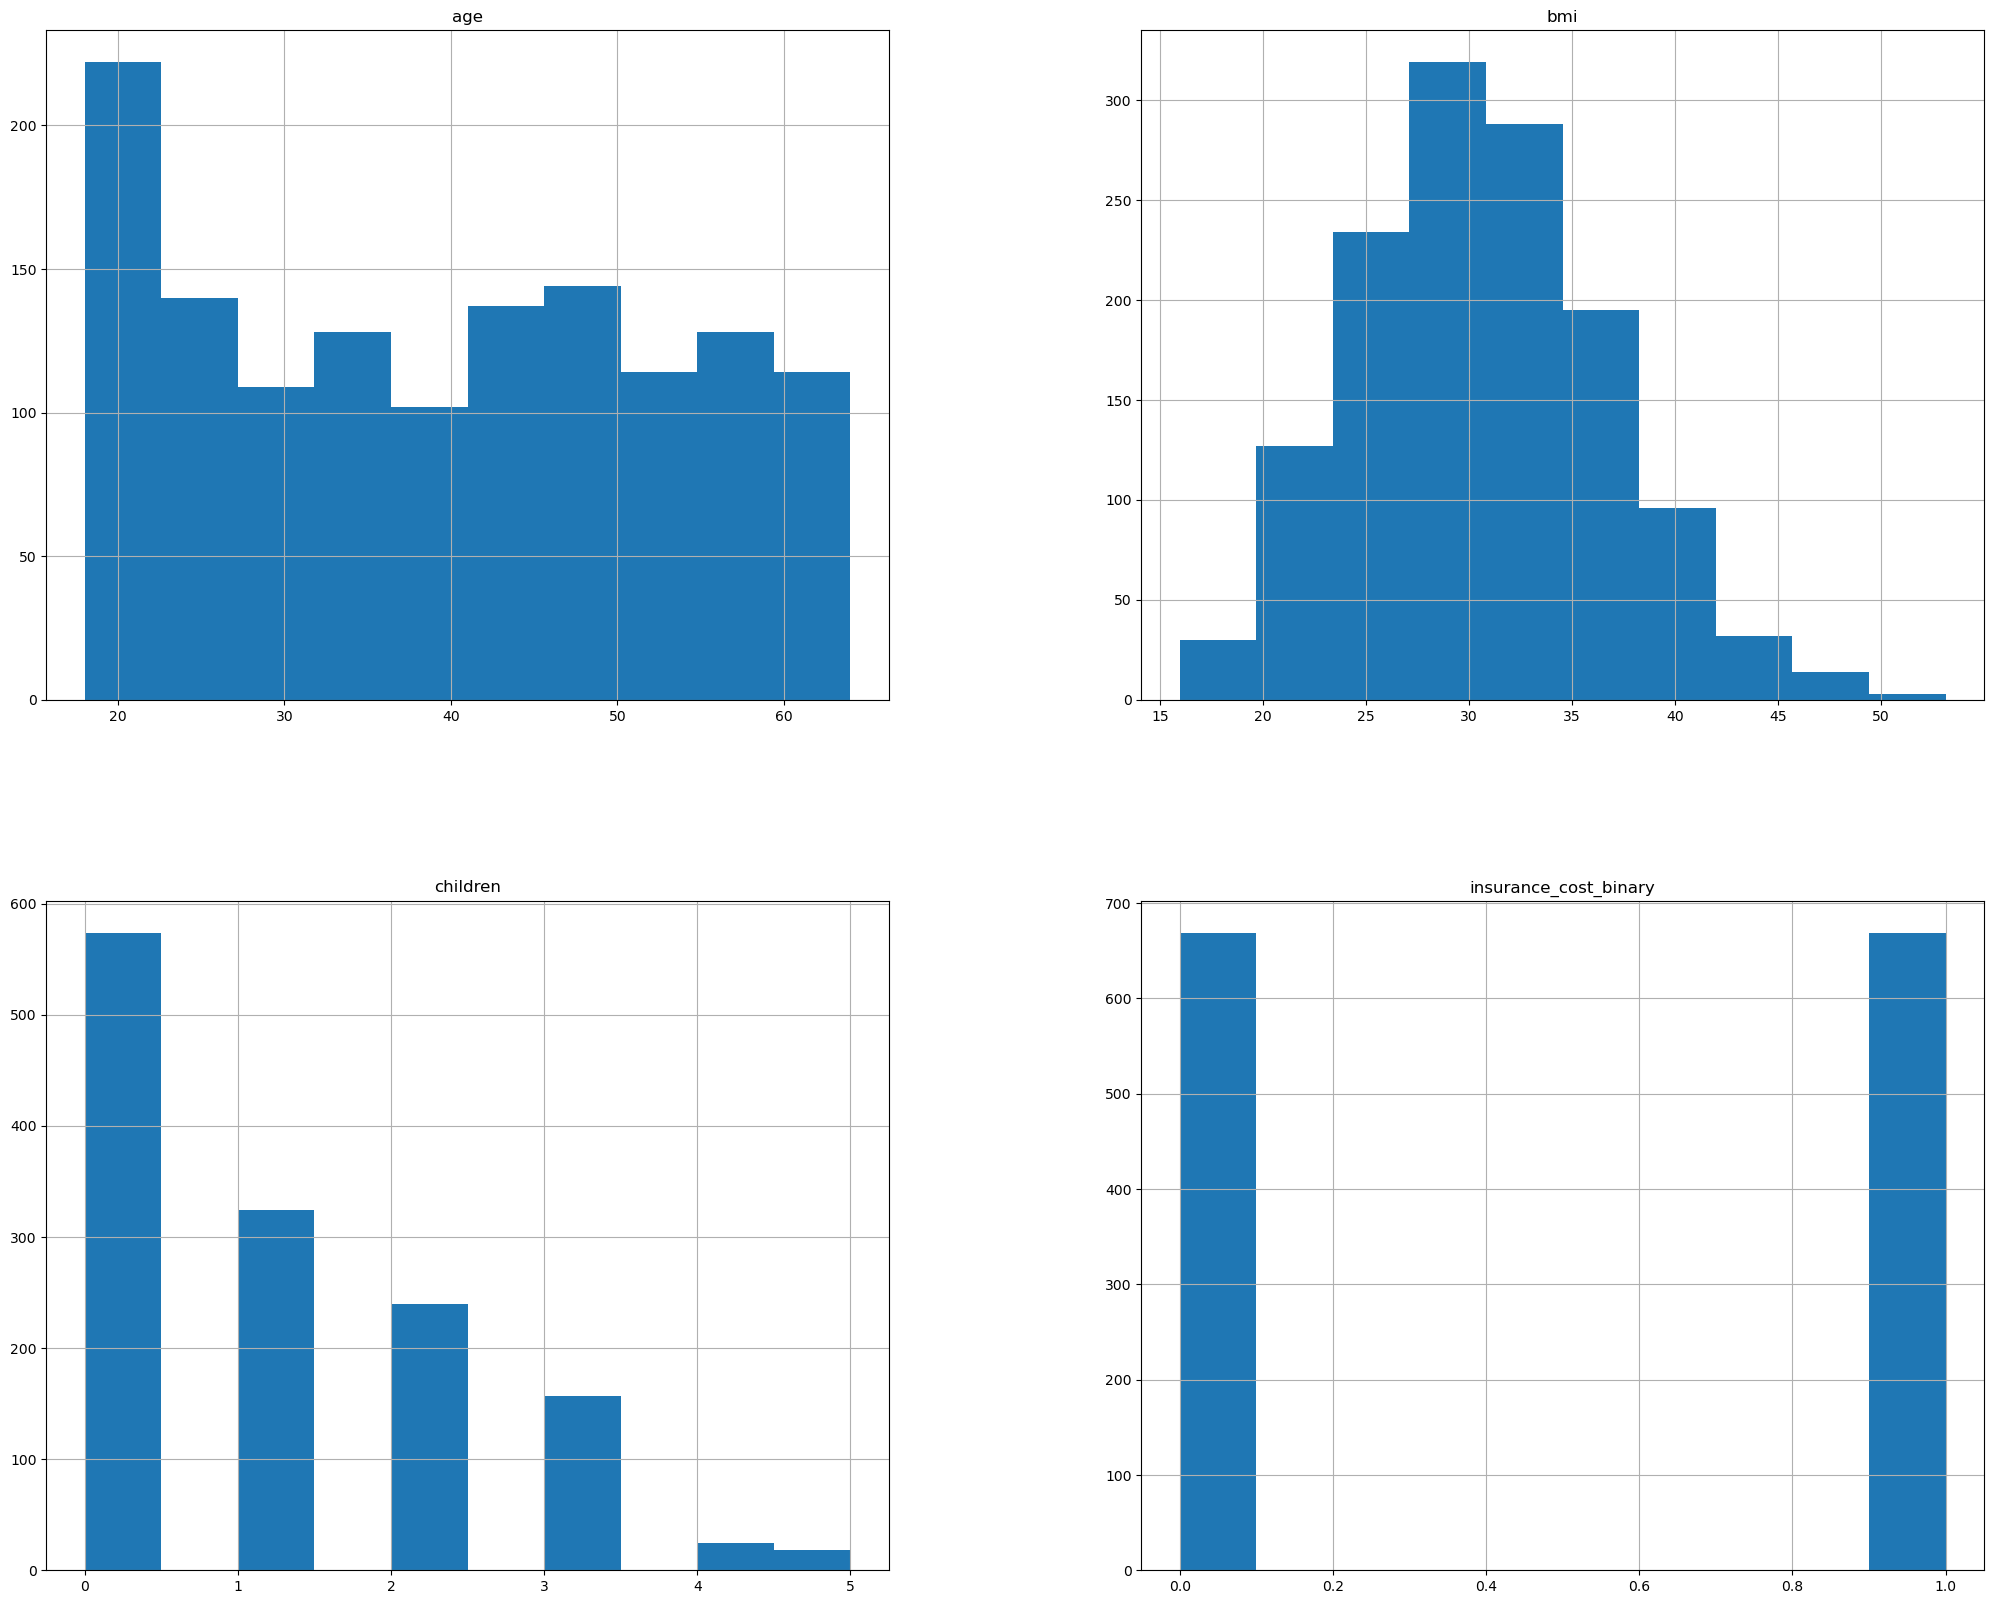

In [144]:
df_clf.hist(bins=10, figsize=(25, 20));

In [152]:
# Drop the `insurance_cost_binary` from the dataset and Set your y to your target variable 
X = df_clf.drop(columns=['insurance_cost_binary'])
y = df_clf['insurance_cost_binary']


In [154]:
df_clf.describe()

age          bmi     children  insurance_cost_binary
count  1338.000000  1338.000000  1338.000000            1338.000000
mean     39.207025    30.663397     1.094918               0.500000
std      14.049960     6.098187     1.205493               0.500187
min      18.000000    15.960000     0.000000               0.000000
25%      27.000000    26.296250     0.000000               0.000000
50%      39.000000    30.400000     1.000000               0.500000
75%      51.000000    34.693750     2.000000               1.000000
max      64.000000    53.130000     5.000000               1.000000

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### 1.1 Preprocessing pipelines

In [156]:
outliers_pipe = Pipeline(
    steps = [ ("scaler", RobustScaler())
    ]
)

no_outliers_pipe = Pipeline(
    steps = [("scaler",MinMaxScaler())
    ]
)

cat_pipe = Pipeline(steps=[('one-hot',OneHotEncoder(handle_unknown='ignore'))
])



preprocess_pipe = ColumnTransformer(
    transformers = [
        ("outliers_pipeline", outliers_pipe, ['bmi']),    
        ("no_outliers_pipeline",no_outliers_pipe, ['age', 'children']),
        ("cat_pipe", cat_pipe, ['smoker', 'region', 'gender'])
    ],
    remainder="passthrough"
)



In [157]:
set_config(display="diagram")
preprocess_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('outliers_pipeline',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['bmi']),
                                ('no_outliers_pipeline',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['age', 'children']),
                                ('cat_pipe',
                                 Pipeline(steps=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['smoker', 'region', 'gender'])])

In [158]:
# Apply preprocessing and convert to DataFrame
df_processed = pd.DataFrame(preprocess_pipe.fit_transform(df_clf))

# Display the first 5 rows of the processed DataFrame
df_processed.head()

0    1    2    3    4    5    6    7    8    9    10   11
0  0.401310  0.0  0.2  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
1  0.440607  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
2 -0.486454  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
3  0.984221  0.0  0.4  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
4  0.622209  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0

### 1.2 Grid Search for Best Parameters and Best Dimensionality Reduction Method and Model training


Train three classification pipelines with SVM, Random Forest, Logistic Regression. 



### SVM

In [177]:
from sklearn.svm import SVC

svm_cfc_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe), 
    ('reduce_dim', 'passthrough'),
    ('svm', SVC(probability=True))
])

In [178]:
N_FEATURES_OPTIONS = [1,2,3,4,5,6,7,8,9]

svm_cfc_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']
    },
    {
        'svm__C': [0.01, 0.1, 1, 10, 100],  
        'svm__gamma': [1, 0.1, 0.01, 0.001], 
        'svm__kernel': ['rbf', 'linear', 'poly']        
    }
]

svm_cfc_search = GridSearchCV(svm_cfc_pipe, svm_cfc_param_grid, n_jobs=-1, cv=5, refit=True)
svm_cfc_search.fit(X_train, y_train)

svm_cfc_best_params = svm_cfc_search.best_params_
svm_cfc_best_model = svm_cfc_search.best_estimator_

print("Best CV score = %0.3f:" % svm_cfc_search.best_score_)
print("Best parameters: ", svm_cfc_best_params)

/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWar

Best CV score = 0.930:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestClassifier()), 'reduce_dim__n_features_to_select': 5, 'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'poly'}


### Random Forest

In [161]:
rfc_pipe = Pipeline(steps=[('preprocess', preprocess_pipe),('reduce_dim', 'passthrough'), ('rf', RandomForestClassifier())])

In [162]:
rfc_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    },
    {
        'rf__n_estimators': [10, 20, 30, 40, 50],
        'rf__max_depth': [2, 4, 6, 8, 10]
    }
]

rfc_search = GridSearchCV(rfc_pipe, rfc_param_grid, n_jobs=-1, cv=5, refit=True)
rfc_search.fit(X_train, y_train)

rfc_best_params = rfc_search.best_params_
rfc_best_model = rfc_search.best_estimator_

print("Best CV score = %0.3f:" % rfc_search.best_score_)
print("Best parameters: ",rfc_best_params )


Best CV score = 0.938:
Best parameters:  {'reduce_dim': RFE(estimator=RandomForestClassifier()), 'reduce_dim__n_features_to_select': 7, 'rf__max_depth': 8, 'rf__n_estimators': 50}


### Logistic Regression

In [163]:
from sklearn.linear_model import LogisticRegression

Log_reg_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe), ('reduce_dim', 'passthrough'),
    ('lr', LogisticRegression())
])


In [164]:
Log_reg_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'lr__C': [0.1, 1.0, 10.0, 100.0],
        'lr__solver': ['liblinear', 'saga']   
    },
    {
        'reduce_dim': [RFE(estimator=RandomForestClassifier())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'lr__C': [0.1, 1.0, 10.0, 100.0], 
        'lr__solver': ['liblinear', 'saga']  
    },
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'lr__C': [0.1, 1.0, 10.0, 100.0],  
        'lr__solver': ['liblinear', 'saga']  
    },
    {
        'lr__C': [0.1, 1.0, 10.0, 100.0],  
        'lr__solver': ['liblinear', 'saga']  
    }    
]

Log_reg_search = GridSearchCV(Log_reg_pipe, Log_reg_param_grid, n_jobs=-1, cv=5, refit=True)
Log_reg_search.fit(X_train, y_train)


Log_reg_best_params = Log_reg_search.best_params_
Log_reg_model = Log_reg_search.best_estimator_

print("Best CV score = %0.3f:" % Log_reg_search.best_score_)
print("Best parameters: ",Log_reg_best_params)

warnings.filterwarnings("ignore", category=ConvergenceWarning)


/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/sit

Best CV score = 0.914:
Best parameters:  {'lr__C': 0.1, 'lr__solver': 'liblinear', 'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 7}


/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Dimension reduction with feature selection pipelines

### 1.3 Compare Classification Models on Test Set

In [179]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [183]:
# Evaluate the SVM model
svm_cfc_accuracy, svm_cfc_precision, svm_cfc_recall, svm_cfc_f1_score, svm_cfc_tpr, svm_cfc_auc = evaluate_model_cfc(X_test, y_test, svm_cfc_best_model)

# Evaluate the Random Forest model
rfc_accuracy, rfc_precision, rfc_recall, rfc_f1_score,rfc_tpr, rfc_auc = evaluate_model_cfc(X_test, y_test, rfc_best_model)

# Evaluate the Naive Bayes model
log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1_score, log_reg_tpr, log_reg_auc= evaluate_model_cfc(X_test, y_test, Log_reg_model)

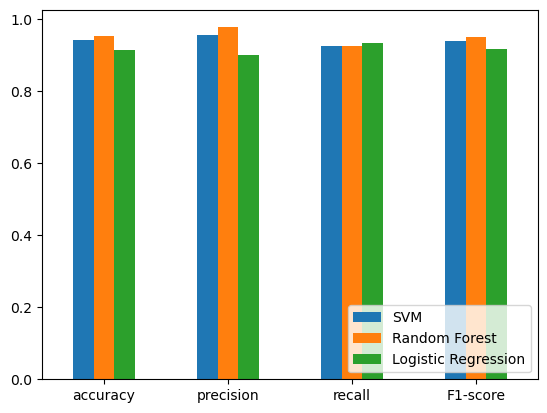

In [184]:
svm_cfc_metrics = np.array([svm_cfc_accuracy, svm_cfc_precision, svm_cfc_recall, svm_cfc_f1_score])
rfc_metrics = np.array([rfc_accuracy, rfc_precision, rfc_recall, rfc_f1_score])
log_reg_metrics= np.array([log_reg_accuracy, log_reg_precision, log_reg_recall, log_reg_f1_score])


index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': svm_cfc_metrics, 'Random Forest': rfc_metrics, 'Logistic Regression':log_reg_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

In [186]:
df_metrics = pd.DataFrame({'SVM': svm_cfc_metrics, 'Random Forest': rfc_metrics, 'Logistic Regression': log_reg_metrics}, index=index)

print("Comparison of Performance Metrics for SVM, Random Forest, and Logistic Regression:")
print(df_metrics)

Comparison of Performance Metrics for SVM, Random Forest, and Logistic Regression:
                SVM  Random Forest  Logistic Regression
accuracy   0.940299       0.951493             0.914179
precision  0.953846       0.976378             0.899281
recall     0.925373       0.925373             0.932836
F1-score   0.939394       0.950192             0.915751


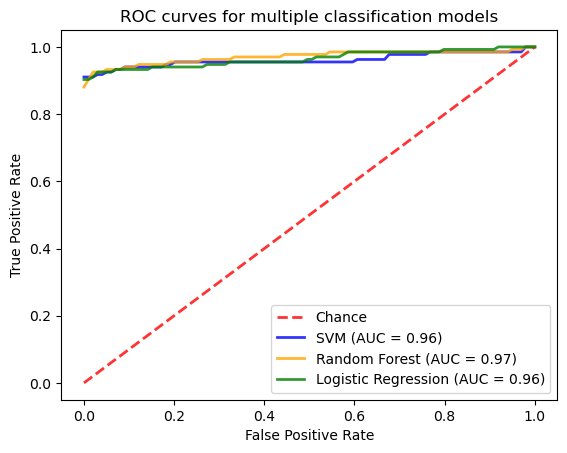

In [193]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, svm_cfc_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (svm_cfc_auc), alpha=0.8)
plt.plot(mean_fpr, rfc_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (rfc_auc), alpha=0.8)
plt.plot(mean_fpr, log_reg_tpr[0,:], lw=2, color='green', label='Logistic Regression (AUC = %0.2f)' % (log_reg_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

### 1.4 Train the Final Model

In [197]:
final_model_cfc = rfc_best_model.fit(X, y)


### 1.5 Summary

The aim of our task is to predict insurance cost classifications based on the provided input variables.Random Forest achieved the highest scores across all metrics, making it the best choice based on the data.

**Performance metrics**

- Overall, SVM, Random Forest and Logistic Regression models perform well across accuracy, precision, and F1-score. 
- Random Forest achieved the highest accuracy, indicating it correctly classified the most insurance cost categories.
- SVM is the next best performer on metrics with the exception of recall where Logistic regression out performs it.


**Metric-Specific Analysis:**

- Accuracy: Random Forest achieves the highest accuracy (0.951493), indicating it correctly classifies the most samples overall.
- Precision: Random Forest again leads with the highest precision (0.976378), meaning it has the best ability to identify true positive cases among its positive predictions.
- Recall: Both SVM and Logistic Regression have the same recall (0.925373), suggesting they are equally effective at finding a high proportion of actual positive cases.
- F1-score: This metric combines precision and recall, and again, Random Forest scores the highest (0.950192), indicating a good balance between identifying true positives and avoiding false positives.

**ROC curves for multiple classification models**

- A ROC curve plots the True Positive Rate (TPR) on the y-axis against the False Positive Rate (FPR) on the x-axis.
    - The ROC curves confirm that all the classification models perform significantly better than a random guess (the red dashed `no skill` line). 

- AUC or area under the curve represents the overall performance of a binary classifier by summarizing the entire ROC curve into a single metric.
    - Random Forest is better performing at 0.97 
    - SVM has an AUC of 0.96
    - Logistic Regression: 0.96 

## Task 2: Regression

In [19]:
df_reg = df.copy()

In [20]:

Xreg = df_reg.drop(columns=['insurance_cost'])
yreg = df_reg['insurance_cost']

# Now you can split your data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(Xreg, yreg, test_size=0.2, shuffle=True, stratify=y)

In [21]:
yreg.head()

0    1725.55230
1    1137.01100
2    2198.18985
3    3393.35635
4    2211.13075
Name: insurance_cost, dtype: float64

### 2.1 Preprocessing pipelines

In [23]:
outliers_pipe_reg = Pipeline(
    steps = [ ("scaler", RobustScaler())
    ]
)

no_outliers_pipe_reg = Pipeline(
    steps = [("scaler",MinMaxScaler())
    ]
)

cat_pipe_reg = Pipeline(steps=[('one-hot',OneHotEncoder(handle_unknown='ignore'))
])



preprocess_pipe_reg = ColumnTransformer(
    transformers = [
        ("outliers_pipeline", outliers_pipe, ['bmi']),    
        ("no_outliers_pipeline",no_outliers_pipe, ['age', 'children']),
        ("cat_pipe", cat_pipe, ['smoker', 'region', 'gender'])
    ],
    remainder="passthrough"
)



In [24]:
set_config(display="diagram")
preprocess_pipe_reg

ColumnTransformer(remainder='passthrough',
                  transformers=[('outliers_pipeline',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['bmi']),
                                ('no_outliers_pipeline',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['age', 'children']),
                                ('cat_pipe',
                                 Pipeline(steps=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['smoker', 'region', 'gender'])])

In [25]:
df_processes_reg = preprocess_pipe_reg.fit_transform(df_reg)
df_processes_reg[:5]

array([[ 4.01309914e-01,  0.00000000e+00,  2.00000000e-01,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.72555230e+03],
       [ 4.40607324e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.13701100e+03],
       [-4.86454302e-01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  2.19818985e+03],
       [ 9.84221494e-01,  0.00000000e+00,  4.00000000e-01,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  3.39335635e+03],
       [ 6.22208991e-01,  0.00000000e+00,  0.0000000

### 2.1 Grid Search for Best Parameters and Best Dimensionality Reduction Method and Model training

We will test 3 models:  Random Forest, Multi-layer Preceptron, Linear regression

### Random Forest

In [26]:
pipeline_random_forest = Pipeline(steps=[("preprocess", preprocess_pipe_reg), 
                       ("reduce_dim", "passthrough"),
                       ("ttr", TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [27]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

In [29]:
from sklearn.feature_selection import f_regression

param_grid_random_forest = [
    {
        "reduce_dim": [PCA()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "ttr__regressor__max_depth": MAX_DEPTH_OPTIONS
    },
    {
        "reduce_dim": [RFE(svm.SVR(kernel="linear", gamma="auto")),RFE(LinearRegression())],
        "reduce_dim__n_features_to_select": N_FEATURES_OPTIONS,
        "ttr__regressor__max_depth": MAX_DEPTH_OPTIONS
    },
    {
        "reduce_dim": [SelectKBest(score_func=f_regression)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "ttr__regressor__max_depth": MAX_DEPTH_OPTIONS
    }  
]

In [54]:
# Define the parameter grid
param_grid = param_grid_random_forest

n_jobs = -1  # Use all available cores

# Perform grid search
grid_search_rf = GridSearchCV(pipeline_random_forest, param_grid, n_jobs=n_jobs, cv=5)
grid_search_rf.fit(X_train, y_train)  # Assuming you have X_train and y_train defined

# Get the best parameters
best_params_rf = grid_search.best_params_
best_model_rf = grid_search_mlp.best_estimator_
print("Best parameters for Random Forest:")
print(best_params_rf)
print("Best CV score = %0.3f:" %  grid_search_rf.best_score_)

Best parameters for Random Forest:
{'reduce_dim': SelectKBest(score_func=<function f_regression at 0x31b68eac0>), 'reduce_dim__k': 11, 'ttr__regressor__max_depth': 4}
Best CV score = 0.858:


###  Multi-layer Perceptron

In [35]:
from sklearn.neural_network import MLPRegressor

MLP_pipe = Pipeline(
    steps=[
        ("preprocess",  preprocess_pipe_reg), 
        ("reduce_dim", "passthrough"),
        ("ttr", TransformedTargetRegressor(
            regressor=MLPRegressor(),
            func=np.log, 
            inverse_func=np.exp)
        )
    ]
)

In [36]:
param_grid_mlp = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],
    },
    {
        'reduce_dim': [RFE(SVR(kernel="linear", gamma="auto")), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],
    },
    {
        'reduce_dim': [SelectKBest(score_func=f_regression)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],
    }  
]

In [52]:
# Perform grid search
grid_search_mlp = GridSearchCV(MLP_pipe, param_grid_mlp, n_jobs=-1, cv=5)
grid_search_mlp.fit(X_train, y_train) 

# Get the best parameters
best_params_mlp = grid_search_mlp.best_params_
best_model_mlp = grid_search_mlp.best_estimator_
print("Best parameters found:")
print(best_params_mlp)

print("Best CV score = %0.3f:" %  grid_search_mlp.best_score_)

/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paulfagan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/paulfagan/ana

Best parameters found:
{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__hidden_layer_sizes': (50, 100, 50)}
Best CV score = 0.842:


### Linear Regression

In [44]:
linear_reg_pipe = Pipeline(
    steps=[
        ("preprocess",  preprocess_pipe_reg), 
        ("reduce_dim", "passthrough"),
        ("ttr", TransformedTargetRegressor(
            regressor=LinearRegression(),
            func=np.log, 
            inverse_func=np.exp)
        )
    ]
)

In [42]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

In [51]:
# Perform grid search
grid_search_lr = GridSearchCV(linear_reg_pipe, param_grid_lr, n_jobs=-1, cv=5)
grid_search_lr.fit(X_train, y_train) 

# Get the best parameters
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_
print("Best parameters found:")
print(best_params_lr)

print("Best CV score = %0.3f:" %  grid_search_lr.best_score_)

Best parameters found:
{'reduce_dim': PCA(), 'reduce_dim__n_components': 6, 'ttr__regressor__fit_intercept': True}
Best CV score = 0.679:


### 2.2 Compare Classification Models on Test Set

In [56]:
rf_mse, rf_mae, rf_r2 = evaluate_model(X_test, y_test, best_model_rf)
mlp_mse, mlp_mae, mlp_r2 = evaluate_model(X_test, y_test, best_model_mlp)
lr_mse, lr_mae, lr_r2 = evaluate_model(X_test, y_test, best_model_lr)

In [58]:
# Create DataFrames for MSE, MAE, and R2 with distinct model names
df_mse = pd.DataFrame({'Random Forest': [rf_mse], 'MLP': [mlp_mse], 'Linear Regression': [lr_mse]}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': [rf_mae], 'MLP': [mlp_mae], 'Linear Regression': [lr_mae]}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': [rf_r2], 'MLP': [mlp_r2], 'Linear Regression': [lr_r2]}, index=['R2'])

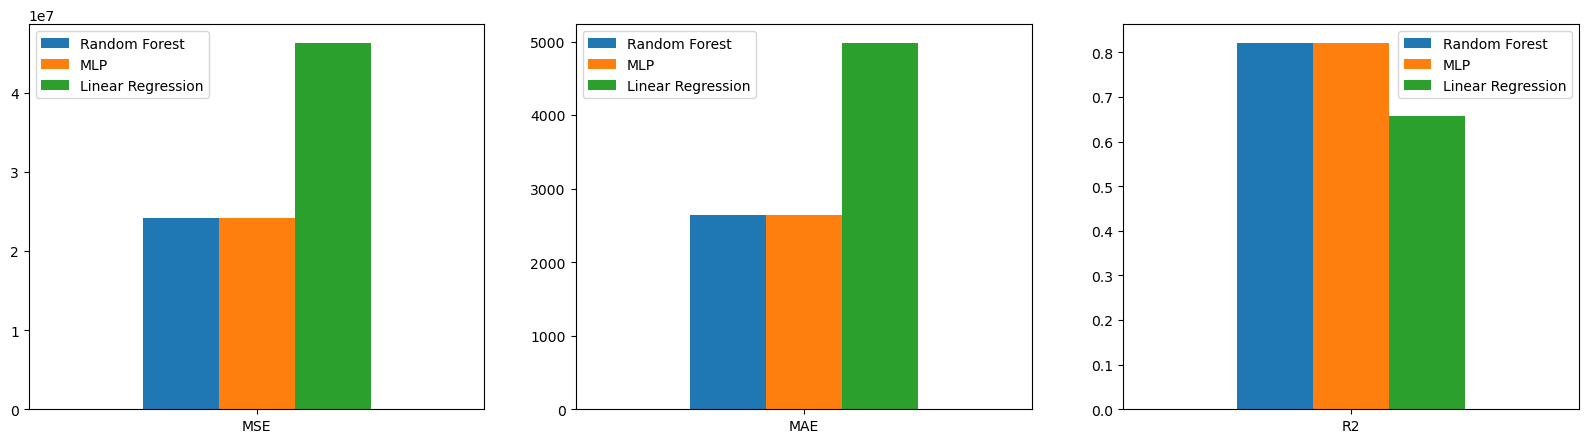

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### 2.4 Summary

The aim of our task is to predict insurance costs based on the provided input variables. On balance, I recommend Linear Regression as focusing on minimizing prediction errors (MSE and MAE) aligns well with the goal of accurately predicting insurance costs .

- Overall, the linear regression outperformed the random forest and MLP on the error metrics MSE and MAE. This means the Linear Regression has the lowest average errors in predicting the target variable. 

- While the both the MLP and Random forest both outperformed Linear Regression in r-squared and so capture a larger portion of the variance in the data. 






**Cross-validation Score summary** 

- Random Forest outperforms both MLP and Linear Regression in terms of CV score, suggesting it captures the underlying relationships in the training data more effectively.
- MLP achieves a slightly lower CV score than Random Forest, potentially due to its higher complexity and the risk of overfitting.
- Linear Regression has the lowest CV score, indicating it might not be as well-suited to the data or the specific task compared to the other models.


Random Forest:

- Achieved the highest CV score (0.858) with the following parameters:
- reduce_dim: SelectKBest with f_regression score function for feature selection.
- reduce_dim__k: Selects 11 features.
- ttr__regressor__max_depth: Maximum depth of the random forest trees is 4.

MLP:

- Obtained the second-best CV score (0.842) with the following parameters:
- reduce_dim: RFE with an SVR (Support Vector Regression) estimator for feature selection.
- reduce_dim__n_features_to_select: Selects 6 features.
- ttr__regressor__hidden_layer_sizes: MLP architecture with three hidden layers (50, 100, 50 neurons).

Linear Regression:

- Had the lowest CV score (0.679) with the following parameters:
- reduce_dim: PCA for dimensionality reduction.
- reduce_dim__n_components: Reduces the data to 6 components.
- ttr__regressor__fit_intercept: Enables fitting an intercept term in the linear regression model.